In [ ]:
import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import zipfile

import sys
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Installation via binaries
print(torch.__version__)

TORCH="'1.7.0'"
CUDA="'cu101'"

!pip install torch-scatter==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-cluster==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-spline-conv==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-geometric

# Installation from source
#!pip install torch-scatter
#!pip install torch-sparse
#!pip install torch-cluster
#!pip install torch-spline-conv
#!pip install torch-geometric

import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

1.7.0+cu101
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 261kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 140kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 7.1MB/s 
     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 235kB 14.9MB/s 
     |████████████████████████████████| 2.2MB 14.3MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=0b69ecd819b6e885ca100542c7578a47358064b17f1cd9169f4e88d9b863c389
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3367c091694ee

In [ ]:
!python --version

Python 3.6.9


In [ ]:
# Download dataset - Takes 5-10 minutes to download and untar
!wget https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/9057631/ANI1_release.tar.gz
!tar -xvf ANI1_release.tar.gz

sys.path.insert(1,'/content/ANI-1_release/readers/lib')
import pyanitools as pya

--2021-01-11 18:50:49--  https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/9057631/ANI1_release.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.91.131
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.91.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4806699125 (4.5G) [binary/octet-stream]
Saving to: ‘ANI1_release.tar.gz’

ANI1_release.tar.gz 100%[===================>]   4.48G  21.9MB/s    in 3m 33s  

2021-01-11 18:54:23 (21.5 MB/s) - ‘ANI1_release.tar.gz’ saved [4806699125/4806699125]

ANI-1_release/
ANI-1_release/ani_gdb_s06.h5
ANI-1_release/ani_gdb_s04.h5
ANI-1_release/ani_gdb_s03.h5
ANI-1_release/readers/
ANI-1_release/readers/example_data_sampler.py
ANI-1_release/readers/lib/
ANI-1_release/readers/lib/pyanitools.py
ANI-1_release/ani_gdb_s01.h5
ANI-1_release/ani_gdb_s08.h5
ANI-1_release/ani_gdb_s07.h5
ANI-1_release/ani_gdb_s02.h5
ANI-1_release/README
ANI-1_release/ani_gdb_s05.h5


In [ ]:
# Copied from example_data_sampler.py
hdf5file = '/content/ANI-1_release/ani_gdb_s01.h5'
adl = pya.anidataloader(hdf5file)

for data in adl:
  P = data['path'] # Won't need
  X = data['coordinates'] # For input feature generation
  E = data['energies'] # For labels
  S = data['species'] # For embedding
  sm = data['smiles'] # Won't need

  # Print the data
  print("Path:   ", P) 
  print("  Smiles:      ","".join(sm)) 
  print("  Symbols:     ", S) 
  print("  Coordinates: ", X) 
  print("  Energies:    ", E, "\n") 

adl.cleanup()

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  [[[-0.0034502   0.01017081  0.01938033]
  [-0.7954868   0.5766599  -0.5472012 ]
  [-0.39378393 -0.97992676  0.2722862 ]
  [ 0.6344988   0.4473651   0.93568736]
  [ 0.59581804 -0.16517928 -0.8915708 ]]

 [[ 0.00311385 -0.02007288  0.00282224]
  [-0.78331304  0.7921426  -0.26027855]
  [-0.45410746 -1.0295471   0.31240797]
  [ 0.44713658  0.63571125  0.76770777]
  [ 0.7531731  -0.1592813  -0.85348135]]

 [[-0.0177954  -0.02192003 -0.01129478]
  [-0.73020756  0.6824338  -0.30819252]
  [-0.382202   -0.86773723  0.3822439 ]
  [ 0.56933683  0.50535196  0.80417496]
  [ 0.75492465 -0.05902938 -0.74378157]]

 ...

 [[ 0.00874467  0.00214323 -0.00896647]
  [-0.85504687  0.6273413  -0.26081228]
  [-0.47105345 -0.9456285   0.3252177 ]
  [ 0.48764503  0.50858426  0.85931367]
  [ 0.7342992  -0.21579494 -0.816997  ]]

 [[ 0.00265332  0.01679167  0.02970096]
  [-0.7641574   0.5417

/content/ANI-1_release/readers/lib/pyanitools.py:47: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)
/content/ANI-1_release/readers/lib/pyanitools.py:59: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dataset = np.array(item[k].value)


In [ ]:
from torch_geometric.data import Data
species_dict = {'H': 0, 'C': 1, 'N': 2, 'O': 3}


class AniDataset(Dataset):
  def __init__(self, dir='ANI-1_release'):
    super(AniDataset, self).__init__()
    self.parse(dir)

  def parse(self, dir):
    self.species = []
    self.pos = []
    self.energies = []
    for i in range(1,9):
      hdf5file = os.path.join(dir,'ani_gdb_s0{}.h5'.format(i))
      adl = pya.anidataloader(hdf5file)
      for molecule in adl:
        species = molecule['species']
        for pos, energy  in zip(molecule['coordinates'], molecule['energies']):
          self.species.append(species)
          self.pos.append(pos)
          self.energies.append(energy)

  @staticmethod
  def get_edge_index(pos):
    dist_mat = np.linalg.norm(pos[None,:,:]-pos[:,None,:],axis=2)
    edge_index = [[],[]]
    N = len(pos)
    for i in range(N):
      for j in range(N):
        if i!=j and dist_mat[i,j]<10:
          edge_index[0].append(i)
          edge_index[1].append(j)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return edge_index

  def __getitem__(self, i):
    pos = self.pos[i]
    species = self.species[i]
    energy = self.energies[i]

    pos = torch.tensor(pos)
    species = torch.tensor([species_dict[atom] for atom in species], dtype=torch.long)
    edge_index = self.get_edge_index(pos)
    energy = torch.tensor(energy)

    graph = Data(x=species, edge_index=edge_index, y=energy, pos=pos)
    return graph

  def __len__(self):
    return len(self.energies)

ani_dataset = AniDataset()

/content/ANI-1_release/readers/lib/pyanitools.py:47: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.store = h5py.File(store_file)
/content/ANI-1_release/readers/lib/pyanitools.py:59: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dataset = np.array(item[k].value)


In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops


class GraphConv(MessagePassing):
    def __init__(self, coors, out_channels_1, out_features, label_dim=1, dropout=0):
        """
        label_dim - dimention of node reprezentaion
        coors - dimension of position (for MNIST 2)
        out_channels_1 - dimension of convolution on each reprezentation chanal 
                        * autput will have dimention label_dim * out_channels_1
        out_features - dimension of node representation after graphConv
        """
        super(GraphConv, self).__init__(aggr='add')
        self.lin_in = torch.nn.Linear(coors, label_dim * out_channels_1)
        self.lin_out = torch.nn.Linear(label_dim * out_channels_1, out_features)
        self.dropout = dropout

    def forward(self, x, pos, edge_index):
        """
        x - feature matrix of the whole graph [num_nodes, label_dim]
        pos - node position matrix [num_nodes, coors]
        edge_index - graph connectivity [2, num_edges]
        """

        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))  # num_edges = num_edges + num_nodes

        return self.propagate(edge_index=edge_index, x=x, pos=pos, aggr='add')  # [N, out_channels, label_dim]

    def message(self, pos_i, pos_j, x_j):
        """
        pos_i [num_edges, coors]
        pos_j [num_edges, coors]
        x_j [num_edges, label_dim]
        """

        tmp = pos_j - pos_i
        L = self.lin_in(tmp)  # [num_edges, out_channels]
        num_nodes, label_dim = list(x_j.size())
        label_dim_out_channels_1 = list(L.size())[1]

        X = F.relu(L)
        Y = x_j
        X = torch.t(X)
        X = F.dropout(X, p=self.dropout, training=self.training)
        result = torch.t(
            (X.view(label_dim, -1, num_nodes) * torch.t(Y).unsqueeze(1)).reshape(label_dim_out_channels_1, num_nodes))
        return result

    def update(self, aggr_out):
        """
        aggr_out [num_nodes, label_dim, out_channels]
        """
        aggr_out = self.lin_out(aggr_out)  # [num_nodes, label_dim, out_features]
        aggr_out = F.relu(aggr_out)
        aggr_out = F.dropout(aggr_out, p=self.dropout, training=self.training)

        return aggr_out

In [ ]:
from torch_geometric.utils import normalized_cut


def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

In [ ]:
from torch_geometric.nn import graclus, max_pool, global_mean_pool

class GeoGCN(torch.nn.Module):
  def __init__(self, dim_coor, out_dim, input_features,
                 layers_num, model_dim, out_channels_1, dropout,
                 use_cluster_pooling):
    super(GeoGCN, self).__init__()
    self.layers_num = layers_num
    self.use_cluster_pooling = use_cluster_pooling

    self.conv_layers = [GraphConv(coors=dim_coor,
                                  out_channels_1=out_channels_1,
                                  out_features=model_dim,
                                  label_dim=input_features,
                                  dropout=dropout)] + \
                        [GraphConv(coors=dim_coor,
                                  out_channels_1=out_channels_1,
                                  out_features=model_dim,
                                  label_dim=model_dim,
                                  dropout=dropout) for _ in range(layers_num - 1)]

    self.conv_layers = torch.nn.ModuleList(self.conv_layers)

    self.fc1 = torch.nn.Linear(model_dim, out_dim)

    self.embedding = nn.Embedding(4,input_features)

  def forward(self, data):
    data.x = self.embedding(data.x)
    data.x = data.x.float()

    for i in range(self.layers_num):
        data.x = self.conv_layers[i](data.x, data.pos, data.edge_index)

        if self.use_cluster_pooling:
            weight = normalized_cut_2d(data.edge_index, data.pos)
            cluster = graclus(data.edge_index, weight, data.x.size(0))
            data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

    #data.x = global_mean_pool(data.x, data.batch)
    x = self.fc1(data.x)

    return torch.sum(x)

In [ ]:
model = GeoGCN(3,1,5,10,16,64,False,False)
#model.cuda()

ani_dataloader = DataLoader(ani_dataset, batch_size=1, pin_memory=True)

objective = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

num_epoch = 10

def train():
  for epoch in range(num_epoch):
    loop = tqdm(total=len(ani_dataloader), position=0, leave=False)
    indices = np.arange(len(ani_dataset))
    np.random.shuffle(indices)
    for idx in indices:
      data = ani_dataset[idx]
      #data = data.cuda()
      data.x = data.x
      data.y = data.y.float()
      optimizer.zero_grad()
      y_hat = model(data)

      loss = objective(y_hat, data.y)
      loss.backward()
      losses.append(loss.item())
      loop.update(1)

      optimizer.step()


train()

KeyboardInterrupt: ignored

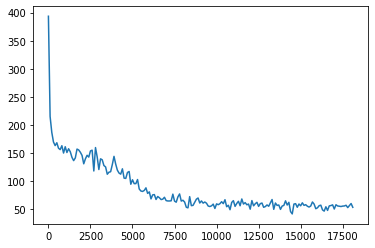

In [ ]:
n=[]
l = []
for i in range(0,len(losses),100):
  l.append(sum(losses[i:i+100])/100)
  n.append(i)
plt.plot(n[:-1],l[:-1])
plt.show()